# Relax's Data Challenge

Defining an "__adopted user__" as a user who has logged into the product on three separate days in at least one seven-day
period, __<i>identify which factors predict future user adoption</i>__.

The data is available as two attached CSV files.

### takehome_users.csv

A user table with data on 12,000 users who signed up for the product in the last two years. This table includes:

- __name__: the user's name
- __object_id__: the user's id
- __email__: email address
- __creation_source__: how their account was created. This takes on one of 5 values:
  - __PERSONAL_PROJECTS__: invited to join another user's personal workspace
  - __GUEST_INVITE__: invited to an organization as a guest (limited permissions)
  - __ORG_INVITE__: invited to an organization (as a full member)
  - __SIGNUP__: signed up via the website
  - __SIGNUP_GOOGLE_AUTH__: signed up using Google Authentication (using a Google email account for their login id)
- __creation_time__: when they created their account
- __last_session_creation_time__: unix timestamp of last login
- __opted_in_to_mailing_list__: whether they have opted into receiving marketing emails
- __enabled_for_marketing_drip__: whether they are on the regular marketing email drip
- __org_id__: the organization (group of users) they belong to
- __invited_by_user_id__: which user invited them to join (if applicable).

### takehome_user_engagement. csv

A usage summary table that has a row for each day that a user logged into the product.

In [1]:
import datetime as dt
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

mpl.rcParams['axes.titlesize'] = 17    # font size for plot title
mpl.rcParams['axes.labelsize'] = 14    # font size for x-axis' and y-axis' label

In [2]:
'''Import data'''

# import users table, exclude cols 'creation_time', 'name', 'email', 'last_session_creation_time', 'org_id'
users = pd.read_csv('takehome_users.csv', encoding='ISO-8859-1', 
                    usecols=lambda col: col not in ['creation_time', 'name', 'email', 
                                                    'last_session_creation_time', 'org_id'])
users.rename(columns={'object_id': 'user_id'}, inplace=True)       # rename 'object_id' to 'user_id'

# user_engagement table
user_engagement = pd.read_csv('takehome_user_engagement.csv', index_col='time_stamp')
user_engagement.index = pd.to_datetime(user_engagement.index)      # convert index's data type to datetime

## New Columns

- __Num of Invitations__ is the number of successfull invitations
- __Average Weekly Logins (Days)__ is the average weekly logins (in days)
- __Adopted User__ True if average weekly logins >= 3.0; otherwise, False

In [3]:
'''Count number of invations for each user'''
invited_by_users = users.groupby(['invited_by_user_id'])['invited_by_user_id'].count().to_frame()
invited_by_users.rename(columns={'invited_by_user_id': 'Num of Invitations'}, inplace=True)
invited_by_users.index.rename('user_id', inplace=True)
invited_by_users.index = invited_by_users.index.astype(int)

# join users and invited_by_group
users = users.set_index('user_id').join(invited_by_users)
users['Num of Invitations'].fillna(0, inplace=True)                     # fill in missing values with zero
users['Num of Invitations'] = users['Num of Invitations'].astype(int)   # change data type to integer

In [4]:
'''Group logins by user_id and date'''
user_engagement['Date'] = user_engagement.index.date
date_group = user_engagement.groupby(['user_id', 'Date']).count().reset_index().set_index('Date')
date_group.index = pd.to_datetime(date_group.index)
date_group['count'] = 1
date_group.drop('visited', axis=1, inplace=True)

'''Aggregate login counts based on 7-days time intervals'''
weekly_logins = date_group.groupby(['user_id']).resample('W-Mon').sum().drop('user_id', axis=1)
weekly_logins.rename(columns={'count': 'Num of Visited Days'}, inplace=True)
weekly_logins.reset_index(inplace=True)

'''Compute average weekly logins by user'''
avg_weekly_logins = weekly_logins.groupby(['user_id'])['Num of Visited Days'].mean().to_frame()
avg_weekly_logins.rename(columns={'Num of Visited Days': 'Average Weekly Logins (Days)'}, inplace=True)

# join users and avg_weekly_logins
users = users.join(avg_weekly_logins)
users['Average Weekly Logins (Days)'].fillna(0, inplace=True)    # fill in missing values with zero

# Adopted User = True if user's average weekly logins >= 3.0; otherwise, False
users['Adopted User'] = users['Average Weekly Logins (Days)'].apply(lambda x: True if x >= 3.0 else False)

# Assign class to creation source
creation_source_dict = {'GUEST_INVITE': 0, 'ORG_INVITE': 1, 'SIGNUP': 2, 
                        'PERSONAL_PROJECTS': 3, 'SIGNUP_GOOGLE_AUTH': 4}
users['creation_source_class'] = users['creation_source'].map(creation_source_dict)

# reorder columns and drop field 'invited_by_user_id'
users = users[['creation_source', 'creation_source_class', 'opted_in_to_mailing_list',
       'enabled_for_marketing_drip', 'Num of Invitations', 'Average Weekly Logins (Days)', 'Adopted User']]

users.head()

,creation_source,creation_source_class,opted_in_to_mailing_list,enabled_for_marketing_drip,Num of Invitations,Average Weekly Logins (Days),Adopted User
user_id,,,,,,,
1,GUEST_INVITE,0,1,0,0,1.0,False
2,ORG_INVITE,1,0,0,0,0.7,False
3,ORG_INVITE,1,0,0,1,1.0,False
4,GUEST_INVITE,0,0,0,0,1.0,False
5,GUEST_INVITE,0,0,0,0,1.0,False


## Exploratory Data Analysis

In [5]:
def annotate_plot(ax, rotation=0, precision=0, pct_precision=0, y_offset=0, n=0, annotate=True):
    for p in ax.patches:
        if n == 0: h_adj = 1
        else: h_adj = 2
        
        x_offset = p.get_width() / 2
        format_str = ',.' + str(precision) + 'f'
        label = format(p.get_height(), format_str)
        x = p.get_x() + x_offset
        y = (p.get_height() + y_offset) / h_adj
        
        if annotate == True:  # annotate value in the middle of bar
            ax.annotate(label, (x,y), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points', rotation=rotation)
        
        if n > 0:    # annotate percentage at the top of each bar
            pct_format_str = '.' + str(pct_precision) + 'f'
            ax.annotate(format(p.get_height()*100 / n, pct_format_str) + '%', 
               (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', 
                xytext = (0, 10), textcoords = 'offset points')

In [7]:
users['Adopted User'].value_counts().to_frame()

,Adopted User
False,11599
True,401


In [8]:
users['Adopted User'].value_counts(normalize=True).to_frame()

,Adopted User
False,0.966583
True,0.033417


- Only __3.34%__ or __401__ of the observed users are __adopted users__.

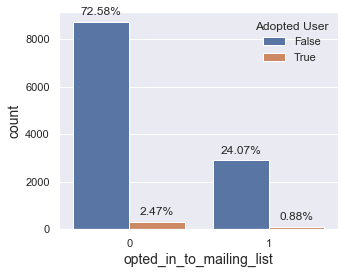

In [9]:
fig, ax = plt.subplots(figsize=(5, 4))

_ = sns.countplot('opted_in_to_mailing_list', data=users, ax=ax, hue='Adopted User')
annotate_plot(ax, n=len(users), pct_precision=2, annotate=False)
plt.legend(frameon=False, title='Adopted User')
plt.show()

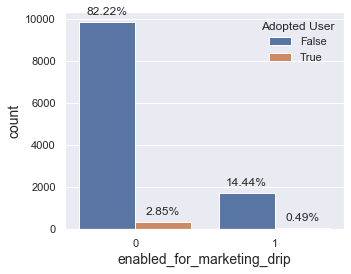

In [10]:
fig, ax = plt.subplots(figsize=(5, 4))

_ = sns.countplot('enabled_for_marketing_drip', data=users, ax=ax, hue='Adopted User')
annotate_plot(ax, n=len(users), pct_precision=2, annotate=False)
plt.legend(frameon=False, title='Adopted User')
plt.show()

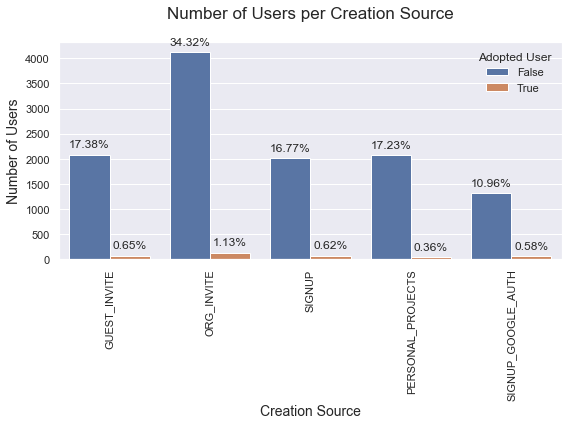

In [11]:
fig, ax = plt.subplots(figsize=(9, 4))

_ = sns.countplot('creation_source', data=users, ax=ax, hue='Adopted User')

annotate_plot(ax, n=len(users), pct_precision=2, annotate=False)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.legend(frameon=False, title='Adopted User')
plt.xlabel('Creation Source')
plt.ylabel('Number of Users')
plt.title('Number of Users per Creation Source\n')
plt.show()

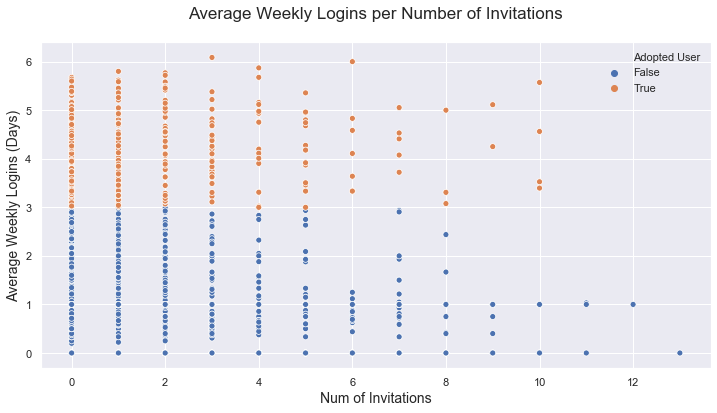

In [12]:
fig, ax = plt.subplots(figsize=(12, 6))

_ = sns.scatterplot('Num of Invitations', 'Average Weekly Logins (Days)', data=users, ax=ax, hue='Adopted User')
annotate_plot(ax, n=len(users), pct_precision=0, annotate=False)
plt.legend(frameon=False, loc='upper right')
plt.title('Average Weekly Logins per Number of Invitations\n')
plt.show()

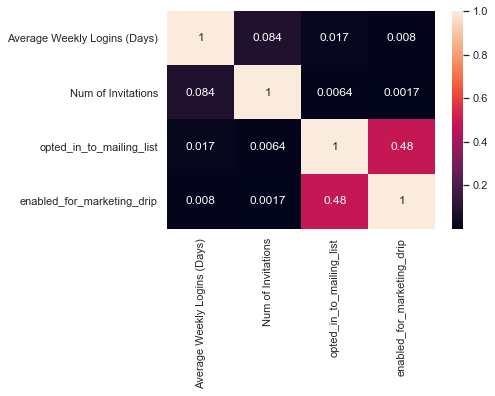

In [13]:
corr = users[['Average Weekly Logins (Days)', 'Num of Invitations', 
              'opted_in_to_mailing_list', 'enabled_for_marketing_drip']].corr()
_ = sns.heatmap(corr, annot=True)
plt.show()

## Predictive Model

__Comment:__

The purpose of predictive model is to identify the factors that can be used to predict adopted users. Since the dataset contains extremely imbalance class, instead of predicting adopted users, we will predict __average weekly logins__ made by the user. If the average weekly logins is 3 days or higher, the user is an adopted user; otherwise, the user is not an adopted user.

__RandomForestRegressor__ is used as a predictive model because it works well with outliers.

In [14]:
from sklearn.model_selection import train_test_split

y = users['Average Weekly Logins (Days)']
X = users[['creation_source_class', 'opted_in_to_mailing_list', 'enabled_for_marketing_drip', 'Num of Invitations']]

# Split dataset into 67% training and 33% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

In [15]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

params = {'max_depth': [3, 5, 10],
          'min_samples_leaf': [5, 6, 7],
          'min_samples_split': [6, 8, 10],
          'n_estimators': [50, 100, 150]}

model = GridSearchCV(estimator=RandomForestRegressor(criterion='mse', random_state=42), 
                                  param_grid=params, cv=3, n_jobs=-1, verbose=2)
model.fit(X_train, y_train)
predicts = model.predict(X_test)
model.best_estimator_

Fitting 3 folds for each of 81 candidates, totalling 243 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   20.1s
[Parallel(n_jobs=-1)]: Done 243 out of 243 | elapsed:   32.9s finished


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=3, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=7,
                      min_samples_split=6, min_weight_fraction_leaf=0.0,
                      n_estimators=50, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

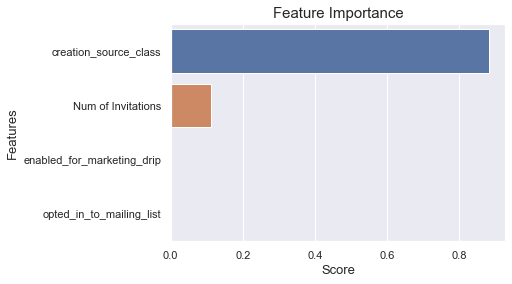

In [19]:
'''Draw plot of Feature Importance'''
fig, ax = plt.subplots(figsize=(6, 4))

# sort feature importance in descending order
feature_imp = pd.Series(model.best_estimator_.feature_importances_, index=X.columns).sort_values(ascending=False)

# create a bar plot of feature importance
sns.barplot(x=feature_imp, y=feature_imp.index)

# add labels to graph
plt.xlabel('Score', size=13)
plt.ylabel('Features', size=13)
plt.title('Feature Importance', size=15)
plt.show()

__Comment:__

The factors that can be used to identify adopted user are:
- Creation source
- Number of invitations

In [18]:
from sklearn import metrics 

mse = metrics.mean_squared_error(y_test, predicts)

print('Mean Absolute Error: %f' % metrics.mean_absolute_error(y_test, predicts))
print('Mean Squared Error: %f' % mse)
print('Root Mean Squared Error: %f' % np.sqrt(mse))
print('R-Squared: %f' % metrics.r2_score(y_test, predicts))

Mean Absolute Error: 0.458801
Mean Squared Error: 0.603364
Root Mean Squared Error: 0.776765
R-Squared: 0.068630


<span style="color:blue">The performance metrics above indicate that the model does not look really good. This indicates that additional measures are needed to help identifying adopted users. In addition, we may also use different models or parameters to see if the performance can be improved.</span>